# Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import necessary libraries

In [3]:
import torch
import os, glob
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
import torchvision
from tqdm import tqdm
from torchsummary import summary

# Bring the dataset into the working directory by extracting dataset.zip from drive

In [ ]:
!unzip '/content/drive/MyDrive/BUBT/Pattern Recognition/Codes/Datasets/CatsVsDogs/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

# Hyperparameters

In [5]:
TRAIN_ROOT = '/content/training_set/training_set'
TEST_ROOT = '/content/test_set/test_set'
CHECKPOINT = ''

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

IMG_SIZE = (256, 256)
BATCH_SIZE = 16

N_CLASSES = 2
print(f"No. of Classes = {N_CLASSES}")

No. of Classes = 2


# Create corresponding train/valid/test Dataframes

In [8]:
def extract_label(path):
    return path.split('/')[-2]

def extract_set(path):
    return path.split('/')[-3]

In [20]:
train_paths = glob.glob('/content/training_set/training_set/*/*.jpg')

train_df = pd.DataFrame({'Path': train_paths})

train_df['Label'] = train_df['Path'].apply(extract_label)
train_df = pd.concat([train_df, pd.get_dummies(train_df['Label'])], axis = 1)

# train_df['Set'] = train_df['Path'].apply(extract_set)

train_df

,Path,Label,cats,dogs
0,/content/training_set/training_set/dogs/dog.15...,dogs,0,1
1,/content/training_set/training_set/dogs/dog.22...,dogs,0,1
2,/content/training_set/training_set/dogs/dog.77...,dogs,0,1
3,/content/training_set/training_set/dogs/dog.14...,dogs,0,1
4,/content/training_set/training_set/dogs/dog.17...,dogs,0,1
...,...,...,...,...
8000,/content/training_set/training_set/cats/cat.33...,cats,1,0
8001,/content/training_set/training_set/cats/cat.24...,cats,1,0
8002,/content/training_set/training_set/cats/cat.19...,cats,1,0
8003,/content/training_set/training_set/cats/cat.27...,cats,1,0


In [21]:
test_paths = glob.glob('/content/test_set/test_set/*/*.jpg')

test_df = pd.DataFrame({'Path': test_paths})

test_df['Label'] = test_df['Path'].apply(extract_label)
test_df = pd.concat([test_df, pd.get_dummies(test_df['Label'])], axis = 1)

# test_df['Set'] = test_df['Path'].apply(extract_set)

test_df

,Path,Label,cats,dogs
0,/content/test_set/test_set/dogs/dog.4359.jpg,dogs,0,1
1,/content/test_set/test_set/dogs/dog.4210.jpg,dogs,0,1
2,/content/test_set/test_set/dogs/dog.4270.jpg,dogs,0,1
3,/content/test_set/test_set/dogs/dog.4276.jpg,dogs,0,1
4,/content/test_set/test_set/dogs/dog.4192.jpg,dogs,0,1
...,...,...,...,...
2018,/content/test_set/test_set/cats/cat.4648.jpg,cats,1,0
2019,/content/test_set/test_set/cats/cat.4092.jpg,cats,1,0
2020,/content/test_set/test_set/cats/cat.4749.jpg,cats,1,0
2021,/content/test_set/test_set/cats/cat.4253.jpg,cats,1,0


# Visualize a random instance from the dataset

Shape of the image: (371, 499, 3)


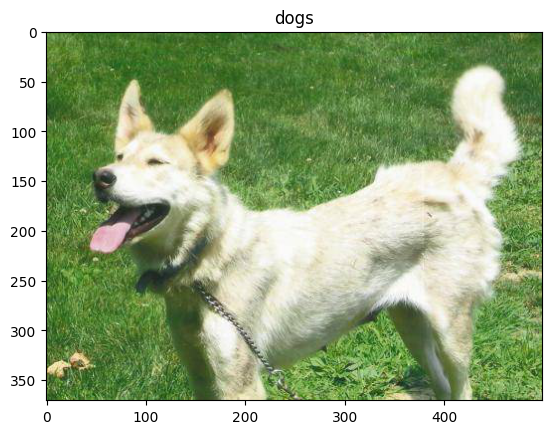

In [22]:
def imshow():
    idx = random.randint(0, len(train_df))
    img = plt.imread(train_df['Path'][idx])
    label = train_df['Label'][idx]
    print(f"Shape of the image: {img.shape}")
    plt.imshow(img)
    plt.title(label)
    plt.show()

imshow()

# Custom Dataloader to read and process the images from dfs

In [25]:
class CustomDatasetLoader(torch.utils.data.Dataset):
    
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        path = self.df.iloc[idx, 0]
        img = cv2.imread(path)
        
        if self.transform:
            img = self.transform(img)
        
        label = torch.from_numpy(self.df.iloc[idx, 2:].values.astype(float))

        return (img, label)

In [26]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(IMG_SIZE),
    torchvision.transforms.ToTensor(),
])

train_data = CustomDatasetLoader(df = train_df, transform = transform)
test_data = CustomDatasetLoader(df = test_df, transform = transform)

train_loader = torch.utils.data.DataLoader(
    dataset = train_data, batch_size = 16, shuffle = True, num_workers = 1, drop_last = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_data, batch_size = 16, shuffle = True, num_workers = 1, drop_last = False
)

In [27]:
for (images, labels) in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 256, 256])
torch.Size([32, 2])


# Model: AlexNet

In [36]:
model = torchvision.models.alexnet(pretrained=True)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [37]:
model.classifier[6] = torch.nn.Linear(
    in_features=model.classifier[6].in_features, out_features=2
)

model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [38]:
model = model.to(DEVICE)
print(f"Model is sent to {DEVICE}")

Model is sent to cuda


In [39]:
random_batch = torch.randn(12, 3, 256, 256)
output = model(random_batch.to(DEVICE))

print(f"{output.shape}\n\n{output}")

torch.Size([12, 2])

tensor([[-1.7058e-01, -2.8441e-02],
        [-3.7677e-01,  6.5311e-02],
        [-3.0987e-01, -1.0102e-01],
        [-2.8321e-01,  3.6102e-02],
        [-4.0752e-01,  1.7195e-02],
        [-3.4504e-01,  3.5337e-04],
        [-4.0109e-01,  1.7246e-01],
        [-2.6783e-01, -6.8378e-02],
        [-6.2220e-01, -9.7591e-02],
        [-3.9426e-01, -1.3239e-02],
        [-5.9428e-01, -1.7029e-01],
        [-5.5602e-01,  1.6260e-02]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [40]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

57012034

In [41]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

# Training pipeline

In [48]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCELoss()

for (images, labels) in tqdm(train_loader):
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    predictions = model(images)
    print(predictions.shape, labels.shape)
    break

  0%|          | 0/250 [00:01<?, ?it/s]


RuntimeError: ignored

In [46]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()

    train_count, correct_predictions, train_loss = 0, 0, 0

    for (images, labels) in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        predictions = model(images)

        optimizer.zero_grad()
        loss = criterion(predictions.to(float), labels)
        loss.backward()
        optimizer.step()

        _, predictions = torch.max(predictions.data, 1)
        _, labels = torch.max(labels.data, 1)

        train_count += labels.shape[0]
        correct_predictions += (predictions == labels).sum().item()
        train_loss += loss.item()
    
    train_acc = correct_predictions / train_count
    train_loss = train_loss / len(train_loader)

    return train_acc, train_loss

# Validation/Test Pipeline

In [43]:
def test(model, dataloader, device):
    model.eval()
    test_count, correct_predictions = 0, 0

    with torch.no_grad():
        for (images, labels) in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            
            predictions = model(images)

            _, predictions = torch.max(predictions.data, 1)
            _, labels = torch.max(labels.data, 1)

            test_count += labels.shape[0]
            correct_predictions += (predictions == labels).sum().item()
        
        test_acc = correct_predictions / test_count

    return test_acc

# Train, validate, test, and evaluate the model, and it's performance

In [44]:
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCELoss()

In [47]:
best_loss, best_acc = 1e10, 0

for epoch in range(50+1):
    print(f"Epoch: {epoch}")

    if os.path.exists('model.pth'):
        model.load_state_dict(torch.load('model.pth'))

    train_acc, train_loss = train(model, train_loader, criterion, optimizer, DEVICE)
    test_acc = test(model, test_loader, DEVICE)
    print(f"Training Accuracy: {train_acc*100:.3f}%, Training Loss: {train_loss:.4f}, Test Accuracy: {test_acc*100:.3f}%\n")
    
    if train_loss < best_loss:
        best_acc = test_acc 
        best_loss = train_loss
        torch.save(model.state_dict(), "model.pth")
        print(f"{'-'*20}\nModel Saved\n{'-'*20}")

Epoch: 0


  0%|          | 0/250 [00:00<?, ?it/s]


RuntimeError: ignored